# imports


In [ ]:
# %pip install seaborn
# %pip install ipykernel
# pip install -r requirements.txt

https://habr.com/ru/companies/ods/articles/323730/  -- со ссылками на другие примеры и датасеты


https://education.yandex.ru/handbook/ml/article/vremennye-ryady

https://sky.pro/wiki/profession/analiz-istoricheskih-dannyh-dlya-prognozirovaniya-vyruchki/

https://habr.com/ru/articles/870200/

https://habr.com/ru/companies/ecom_tech/articles/698118/

https://habr.com/ru/articles/207160/ --ARIMA


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose #для статистических моделей (ARIMA, экспоненциальное сглаживание)

import mysql.connector as myPy
from mysql.connector import Error

from scipy import stats as st
from prophet import Prophet # для моделей машинного обучения

import os
from dotenv import load_dotenv
import json
import datetime as dt
from datetime import date


c:\Python311\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde
c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# connect

In [8]:
connector_parametrs = {'host':"localhost",
                        'port':3306,
                        'dbname':'crmsql',
                        'user':'root',
                        'password':'Sansay1'
                        }


# for products

In [4]:
try:
    connector = myPy.connect(host=connector_parametrs['host'],
                        port=connector_parametrs['port'],
                        database=connector_parametrs['dbname'],
                        user=connector_parametrs['user'],
                        password=connector_parametrs['password'])
    
    query = """SELECT date, product_id, 
			        count(product_id)*price AS revenue
                FROM sales
	                INNER JOIN price USING (product_id)
                GROUP BY  1, 2
                ORDER BY 1"""
    df_sales_dymanic = pd.read_sql(query, connector)

except Error as e:
    print(f'Ошибка:{e}')

finally:
    if connector and connector.is_connected():
        connector.close()
        print('Соединение закрыто вручную')


# display(df_sales_dymanic[df_sales_dymanic['product_id'] == 1].head())


C:\Users\aigna\AppData\Local\Temp\ipykernel_20976\3651149323.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sales_dymanic = pd.read_sql(query, connector)


Соединение закрыто вручную


Text(0, 0.5, 'Выручка')

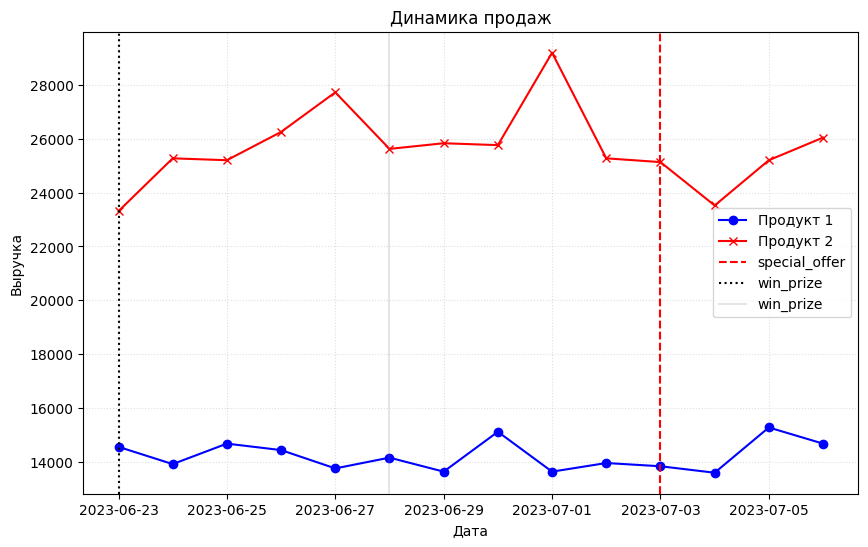

In [8]:
df_sales_dymanic['date'] = pd.to_datetime(df_sales_dymanic['date'])

# df_sales_dymanic['revenue'].hist()
figure_dinamic_prod1 = plt.figure(figsize= (10,6))
plt.plot(df_sales_dymanic[df_sales_dymanic['product_id'] == 1]["date"],df_sales_dymanic[df_sales_dymanic['product_id'] == 1]['revenue'], label='Продукт 1', marker='o', color='blue')
plt.plot(df_sales_dymanic[df_sales_dymanic['product_id'] == 2]["date"],df_sales_dymanic[df_sales_dymanic['product_id'] == 2]['revenue'], label='Продукт 2', marker='x', color='red')
# plt.plot(df_sales_dymanic["date"],df_sales_dymanic['revenue'], label='Продукт 2', marker='x', color='red')
# plt.scatter(data = df_sales_dymanic[df_sales_dymanic['product_id'] == 1], x="date", y = 'revenue')
# Добавляем вертикальную линию для конкретной даты
plt.axvline(x=dt.date(2023, 7, 3), color='red', linestyle='--', label='special_offer')
plt.axvline(x=dt.date(2023, 6, 23), color='black', linestyle=':', label='win_prize')
plt.axvline(x=dt.date(2023, 6, 28), color='grey', linestyle='-', label='win_prize', alpha = 0.2)

plt.title("Динамика продаж")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.4)
plt.xlabel("Дата")
plt.ylabel("Выручка")

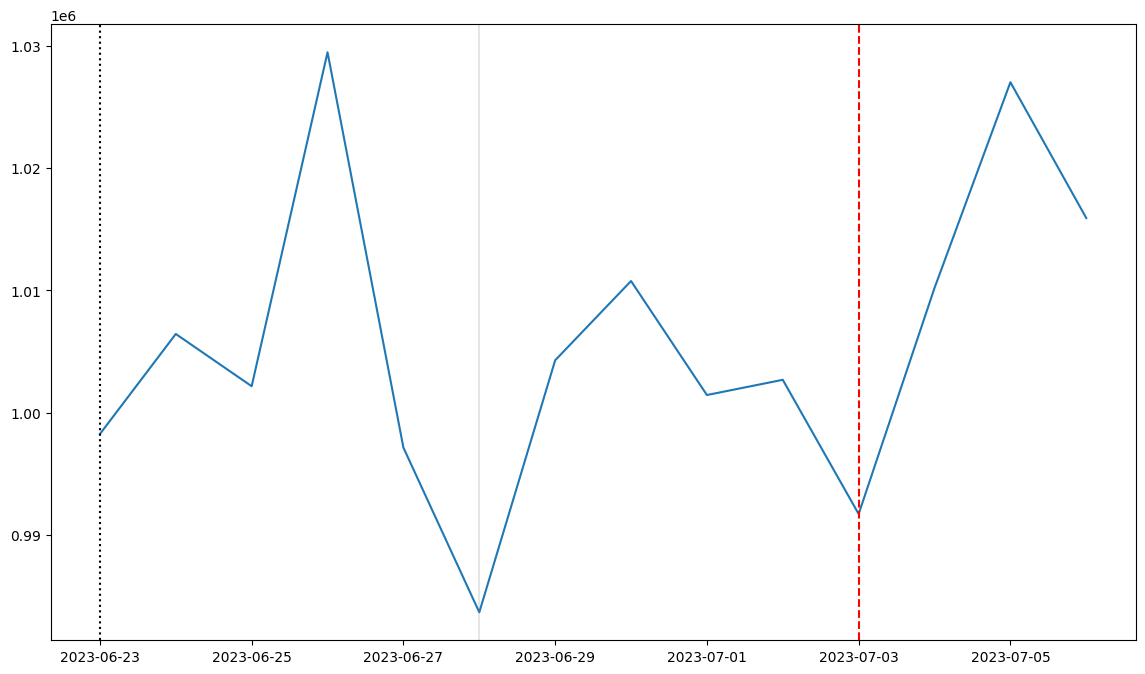

In [5]:
df_grop_date = df_sales_dymanic.groupby(by='date', as_index=False).agg(all_sales =('revenue', 'sum'))
fig_all_sales = plt.figure(figsize=(14, 8))
plt.plot(df_grop_date['date'], df_grop_date['all_sales'])
plt.axvline(x=dt.date(2023, 7, 3), color='red', linestyle='--', label='special_offer')
plt.axvline(x=dt.date(2023, 6, 23), color='black', linestyle=':', label='win_prize')
plt.axvline(x=dt.date(2023, 6, 28), color='grey', linestyle='-', label='win_prize', alpha = 0.2)


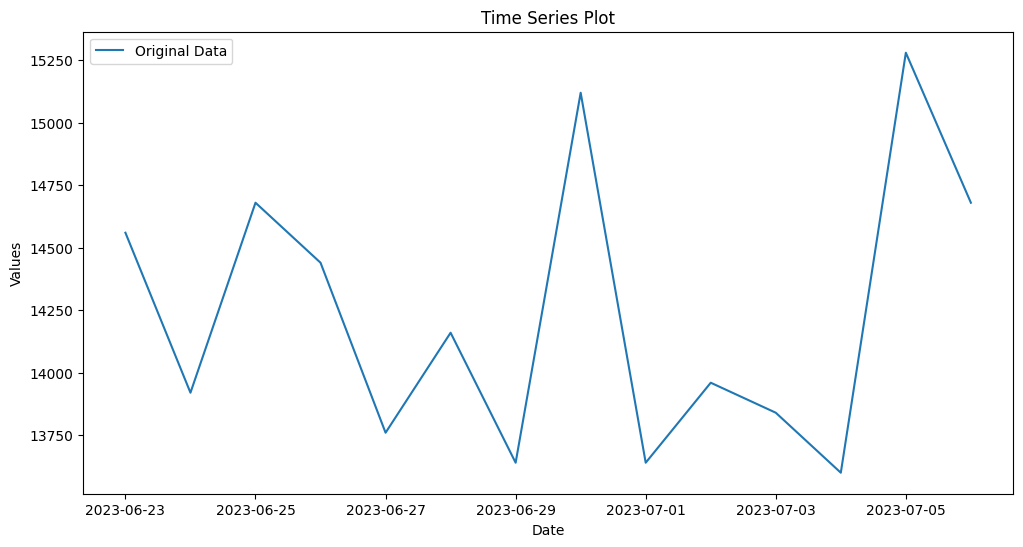

In [7]:
df_1 = df_sales_dymanic[df_sales_dymanic['product_id'] == 1]
df_1.set_index('date', inplace=True)
df_1

plt.figure(figsize=(12, 6))
plt.plot(df_1.index, df_1['revenue'], label='Original Data')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
result = seasonal_decompose(df_1['revenue'], model='additive') 
result

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,8))
axes[0].plot(result.observed, color="black")
axes[0].set_title("Observed")
axes[1].plot(result.trend, color="blue")
axes[1].set_title("Trend")
axes[2].plot(result.seasonal, color="green")
axes[2].set_title("Seasonality")
axes[3].plot(result.resid, color="red")
axes[3].set_title("Residuals")
plt.tight_layout()
plt.show()

In [ ]:
df_sales_dymanic['Day'] = df_sales_dymanic['date'].apply(lambda x: x.weekday())
df_sales_dymanic

# for customer with promo and date

In [24]:
try:
    connector = myPy.connect(host=connector_parametrs['host'], port=connector_parametrs['port'],database=connector_parametrs['dbname'],
                             user=connector_parametrs['user'],password=connector_parametrs['password'])
    
    query_promo1 = """SELECT Date As Order_date, id_customer, cell_package_sk,  start_date As Promo_date,  price, SUM(product_id*price) As Revenue
FROM campaning
	INNER JOIN sendings USING (campaning_SD)
	INNER JOIN response USING (cell_package_sk)
	INNER JOIN sales USING(id_customer)
    INNER JOIN price USING(product_id)
GROUP BY 1,2,3, 4, 5"""
    df_promo1 = pd.read_sql(query_promo1, connector)

except Error as e:
    print(f'Ошибка:{e}')

finally:
    if connector and connector.is_connected():
        connector.close()
        print('Соединение закрыто вручную')

# df_promo1[df_promo1['id_customer'] == 16] 
df_promo1['DiffDate'] = df_promo1['Order_date'] - df_promo1['Promo_date']
df_promo1['Promo'] = df_promo1['DiffDate'].apply(lambda x: 1 if ((x <= dt.timedelta(days=3)) & (x>= dt.timedelta(days=0))) else 0)

# df_promo1.sort_values('id_customer')['Res'].value_counts(normalize=True)

# df_promo1.groupby(by= 'cell_package_sk', as_index=False).agg(total_revenue = ('Revenue','sum'))
df_promo1['Day_nm'] = df_promo1['Order_date'].apply(lambda x: x.weekday())
# df_promo1['Month_nm'] = df_promo1['Order_date'].apply(lambda x: x.month())

day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
months = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь", "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]
df_promo1['Week_day'] = df_promo1['Day_nm'].apply(lambda x: day_names[x])
df_promo1['Month'] = df_promo1['Order_date'].apply(lambda x: months[x.month-1])
df_promo1.head(3)

df_sales_clear = df_promo1[['Order_date', 'id_customer', 'price', 'Promo','Week_day','Month', 'Revenue']].sort_values('Order_date').copy()
# display(df_sales_clear.head())
df_sales_clear_promo = df_sales_clear.groupby(by=['Order_date','Promo'], as_index=False).agg(all_sales =('Revenue', 'sum')) #.sort_values('Order_date')
df_sales_clear_promo.head(2)

C:\Users\aigna\AppData\Local\Temp\ipykernel_20976\2173460747.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_promo1 = pd.read_sql(query_promo1, connector)


Соединение закрыто вручную


,Order_date,Promo,all_sales
0,2023-06-23,0,7163710.0
1,2023-06-23,1,4385665.0


# Propher только для общих объемов по дате

16:57:42 - cmdstanpy - INFO - Chain [1] start processing
16:57:42 - cmdstanpy - INFO - Chain [1] done processing


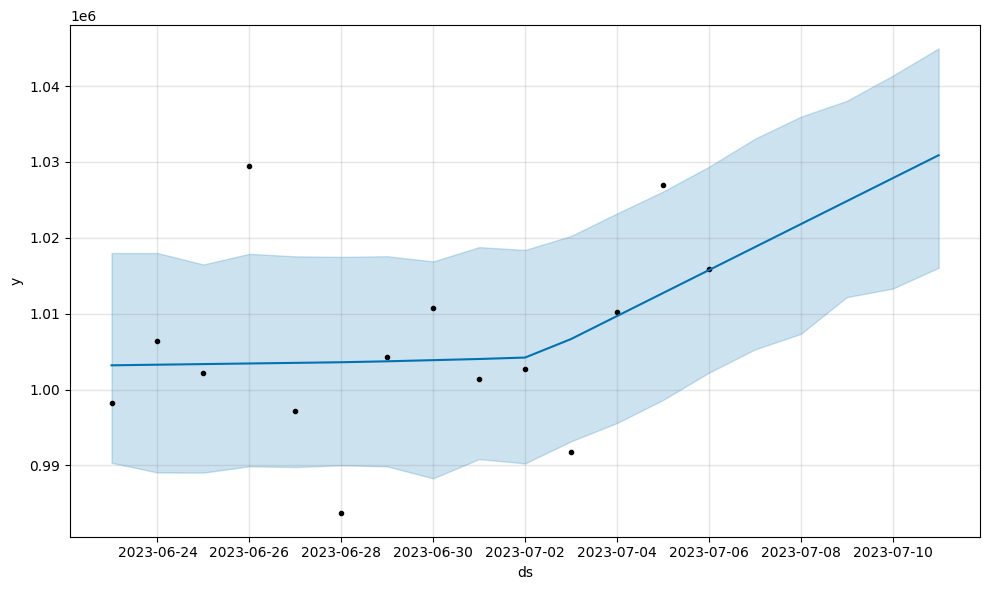

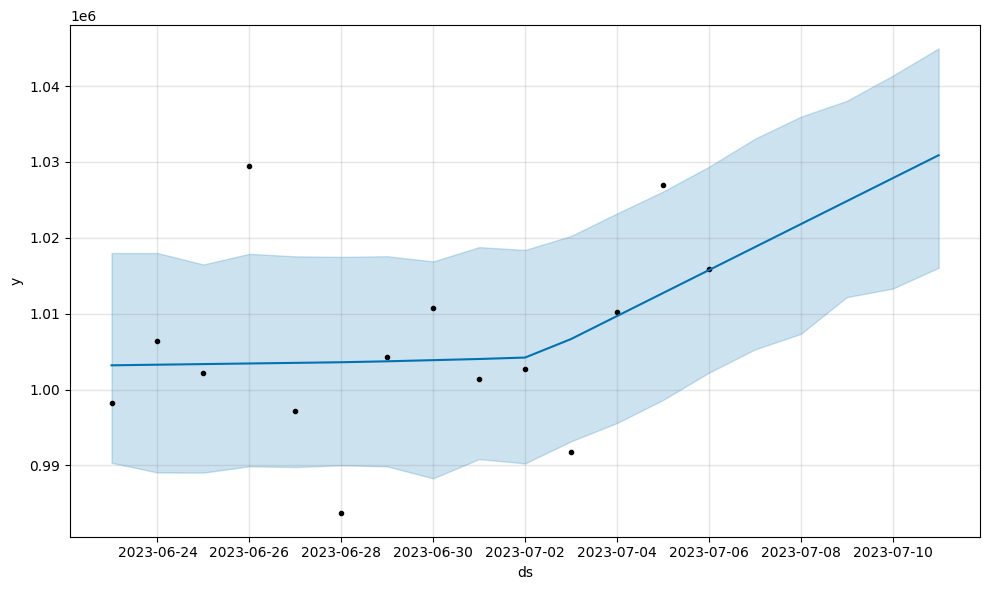

In [23]:
df_propher = df_grop_date.copy()
df_propher.rename(columns={'date' : "ds", 'all_sales' : "y"}, inplace=True)
# df_propher

model_propher = Prophet()
model_propher.fit(df_propher)

future_5_days = model_propher.make_future_dataframe(periods=5)
# future_5_days

forcast = model_propher.predict(future_5_days)



# fig = plt.figure(figsize= (10, 5))
# plt.plot(forcast['ds'], forcast['yhat'], marker='o')
# plt.xticks(rotation=45);

model_propher.plot(forcast)

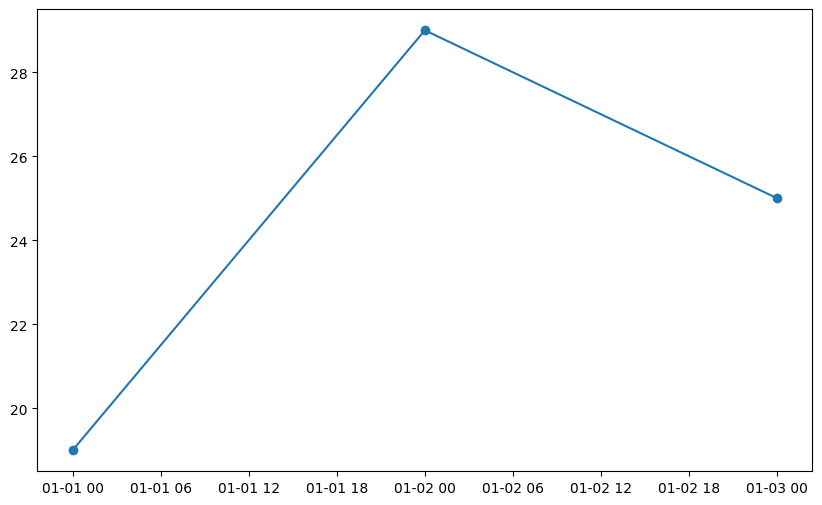

In [11]:
data = {
    'dates': ['2023-01-01', '2023-01-02', '2023-01-03'],
    'values': [10, 20, 15]    ,
    'values': [19, 29, 25]
}

df = pd.DataFrame(data)

# Преобразование строковых дат в объект datetime
df['dates'] = pd.to_datetime(df['dates'])

# Создание графика
plt.figure(figsize=(10, 6))  # Опциональный параметр размера окна графика

# Рисуем линию графика
plt.plot(df['dates'], df['values'], marker='o')  # marker добавляет маркеры точек

# # Настройка меток оси X
# plt.xticks(df['dates'], rotation=45)  # rotation поворачивает метки на 45 градусов для лучшей читаемости

# # Названия осей
# plt.xlabel('Даты')
# plt.ylabel('Значения')

# # Название графика
# plt.title('График изменения значений по датам')

# # Показываем график
# plt.grid(True)  # Включаем сетку для наглядности
plt.show()